# Projekt 01: Analiza danych medycznych z wykorzystaniem tradycyjnych metod uczenia maszynowego

## Analiza zbioru danych ae_retro

# Metoda Analizy
1. Dokonaj binaryzacji klasy decyzyjnej, gdzie klasa pozytywna obejmuje klasę lub klasy istotne (‼), natomiast klasa negatywna pozostałe klasy
2. Zbuduj klasyfikator bazowy (proste rozwiązanie wykorzystujące typowe techniki, np. regresję logistyczną) oraz klasyfikator docelowy dopasowany do rozważanego problemu decyzyjnego. Klasyfikator docelowy może obejmować bardziej złożony pipeline z krokami odpowiedzialnymi za wstępne przetwarzanie danych uczących.
3. Do oceny klasyfikatora użyj 5-krotnej warstwowej walidacji krzyżowej (stratified cross validation) powtórzonej 3-krotnie.
4. Podczas każdej iteracji wykonaj następujące czynności:
  - a. Dokonaj oceny zaproponowanych klasyfikatorów (bazowy i docelowy) na zbiorze testowym wykorzystując miary AUPRC (area under the precision-recall curve) oraz AUROC (area under the ROC curve). AUPRC jest lepiej dopasowana do danych niezrównoważonych [2], AUROC stanowi jej uzupełnienie.
  - b. Dla każdego z klasyfikatorów wyznacz na podstawie zbioru uczącego progi
  średniego i wysokiego ryzyka (medium- and high-risk thresholds) [3]:
    - i. Próg medium-risk = próg, dla którego sensitivity >= 99%,
    - ii. Próg high-risk = próg, dla którego specificity >= 90%.
  - c. Zastosuj progi do klasyfikacji danych testowych wykorzystując ciągłą odpowiedź
  klasyfikatora (response):
    - i. Jeśli response < medium-risk, wówczas decyzja = negative
    - ii. Jeśli response >= high-risk, wówczas decyzja = positive
    - iii. Domyślnie brak odpowiedzi („szara strefa” – umiarkowane ryzyko)
  - d. Wyznacz miary false-negative rate (FNR) oraz false-positive rate (FPR) dla przykładów testowych zaklasyfikowanych odpowiednio jako negative i positive
5. Po wykonaniu wszystkich iteracji (3*5-fcv) wyznacz uśrednione wielkości
- a. AUPRC i AUROC
- b. FNR i TNR
- c. Odsetek przykładów uczących zaklasyfikowanych jako negative i positive przy użyciu progów medium-risk oraz high-risk

### Import bibliotek

In [1]:
%matplotlib inline

import numpy as np
from pandas import DataFrame
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Wczytanie i transformacja danych

In [2]:
def transform_num(value: str) -> float | str:
  def is_num(value: str) -> bool:
    try:
      float(str(value).replace(',', '.'))
      return True
    except ValueError:
      return False

  def as_num(value: str) -> float:
    return float(str(value).replace(',', '.'))

  match value:
    case _ if is_num(value): return as_num(value)
    case _: return value

def transform_bool(value: str) -> bool | str:
  match value:
    case 'YES': return True
    case 'NO': return False
    case _: return value

def transform_category(value: str) -> bool:
  return value != 'SHORT'

In [3]:
dataframe = pd.read_csv('resources/datasets/ae_retro/discretized.csv', na_values=('?',))

attribute_key_map = {
  'REG_AGE': 'registartion_age',
  'PRIM_CARE': 'primary_care',
  'CHEST_CLINIC': 'chest_clinic',
  'CURR_INH_STEROID': 'current_inhaled_steroids',
  'AGE_FIRST_SX': 'age_of_first_symptoms',
  'PREV_ORAL_STEROID': 'previous_oral_steroids',
  'PREV_ED_LAST_YEAR': 'previous_ed_last_year',
  'PREV_ADM': 'previous_admission',
  'ENV_SMOKE': 'smokey_environment',
  'ENV_DANDER': 'dander_in_environment',
  'ENV_CARPETS': 'carpets_in_environment',
  'ALLG_ENV': 'allergic_environment',
  'ALLG_PETS': 'allergric_pets',
  'ALLG_FOOD': 'allergic_food',
  'PTHX_ATOPY': 'PTHX_atopy',
  'FMHX_ASTHMA': 'FMHX_asthma',
  'ALLG_EXP': 'allergy_exposure',
  'URTI_SX': 'URTI_symptoms',
  'FEVER': 'fever',
  'DUR_ASTHMA_SX': 'duration_of_symptoms',
  'VENT_LAST_24H': 'ventilation_in_last_24h',
  'ARRV_ED': 'arrival_to_ed',
  'CORR_CATEGORY': 'category',
  'TRIAGE_TEMP': 'triage_temperature',
  'TRIAGE_RESP_RATE': 'triage_respiratory_rate',
  'TRIAGE_HEART_RATE': 'triage_heart_rate',
  'TRIAGE_SAO2': 'triage_oxygen_saturation',
  'TRIAGE_SAO2_ENV': 'triage_oxygen_environment',
  'TRIAGE_AIR_ENTRY': 'triage_air_entry',
  'TRIAGE_DISTRESS': 'triage_distress',
  'TRIAGE_COLOUR': 'triage_skin_colour',
  'TRIAGE_EXP_WHEEZE': 'triage_expiratory_wheeze',
  'TRIAGE_INSP_WHEEZE': 'triage_inspiratory_wheeze',
  'TRIAGE_RETRACTIONS': 'triage_retractions',
  'REASS_TEMP': 'reassesment_temperature',
  'REASS_RESP_RATE': 'reassesment_respiratory_rate',
  'REASS_HEART_RATE': 'reassesment_heart_rate',
  'REASS_SAO2': 'reassesment_oxygen_saturation',
  'REASS_SAO2_ENV': 'reassesment_oxygen_environment',
  'REASS_AIR_ENTRY': 'reassesment_air_entry',
  'REASS_DISTRESS': 'reassesment_distress',
  'REASS_COLOUR': 'reassesment_skin_colour',
  'REASS_EXP_WHEEZE': 'reassesment_expiratory_wheeze',
  'REASS_INSP_WHEEZE': 'reassesment_inspiratory_wheeze',
  'REASS_RETRACTIONS': 'reassesment_retractions',
  'REASS_RX_TYPE': 'reassesment_treatment_type',
  'RX_OTHER': 'treatment_other',
}

dataframe = (
  dataframe[dataframe['DECISION_OFFSET'] == 60]
  .drop(columns=['DECISION_OFFSET'])
  .rename(columns=attribute_key_map)
  .map(transform_num)
  .map(transform_bool)
)

dataframe['category'] = dataframe['category'].map(transform_category)

### Analiza danych - Przedstawienie zbioru

In [4]:
dataframe.head()

,registartion_age,primary_care,chest_clinic,current_inhaled_steroids,age_of_first_symptoms,previous_oral_steroids,previous_ed_last_year,previous_admission,smokey_environment,dander_in_environment,...,reassesment_heart_rate,reassesment_oxygen_saturation,reassesment_air_entry,reassesment_distress,reassesment_skin_colour,reassesment_expiratory_wheeze,reassesment_inspiratory_wheeze,reassesment_retractions,NUM_MASKS,category
0,GE_3Y_LT_7Y,FD,False,NaN,GE_1Y_LT_3Y,GE_1M_LT_3M,2_VISITS,FLOOR,NaN,NaN,...,NORMAL,NaN,NaN,NONE,PINK,PRESENT,PRESENT,NaN,0.0,True
1,GE_3Y_LT_7Y,FD,False,PRN,GE_3Y,GE_12M,NONE,NONE,NaN,NaN,...,NaN,GE_93_LT_95,GOOD,NaN,NaN,ABSENT,ABSENT,ABSENT,1.0,False
4,GE_3Y_LT_7Y,FD,True,PRN,GE_1Y_LT_3Y,GE_3M_LT_12M,GE_4_VISITS,FLOOR,NaN,NaN,...,NaN,NaN,GOOD,NaN,NaN,ABSENT,ABSENT,PRESENT,1.0,False
5,GE_3Y_LT_7Y,FD,True,PRN,GE_1Y_LT_3Y,GE_3M_LT_12M,GE_4_VISITS,FLOOR,NaN,NaN,...,ABNORMAL,GE_93_LT_95,GOOD,NaN,PALE,PRESENT,PRESENT,PRESENT,3.0,True
7,GE_7Y,FD,False,NONE,GE_3Y,GE_3M_LT_12M,2_VISITS,NONE,NaN,NaN,...,NaN,NaN,REDUCED,NONE,NaN,PRESENT,NaN,PRESENT,1.0,False


#### Wykresy

C:\Users\HououinKyouma\AppData\Local\Temp\ipykernel_29120\1706945137.py:129: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


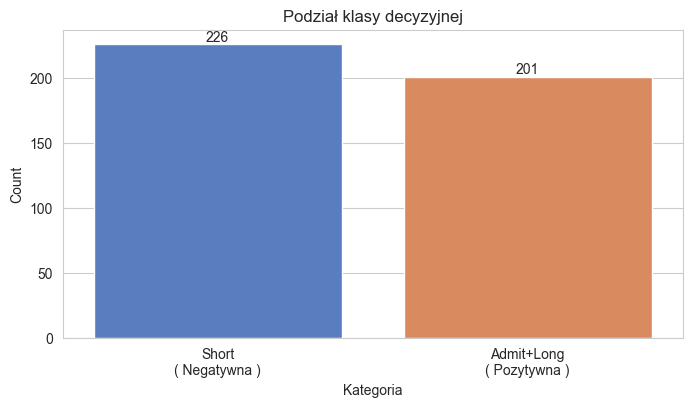

In [5]:
from matplotlib.axes import Axes
def show_missing_values(dataframe: DataFrame):
  dataframe = (
    dataframe
    .isnull()
    .sum()
    .reset_index()
    .rename(columns={
      'index': 'column_name',
      0: 'counts',
    })
    .sort_values('counts')
    .query('counts > 0')
  )

  figure = plt.figure(figsize=(24, 10))

  axis = sns.barplot(
    x='counts',
    y='column_name',
    data=dataframe,
    palette='muted', hue='column_name',
    figure=figure
  )
  for bar in axis.containers: axis.bar_label(bar)

  axis.set(
    title='Missing Values',
    xlabel='Count',
    ylabel='Column Name'
  )
  figure.show()

def show_correlation(dataframe: DataFrame):
  dataframe = dataframe.copy(deep=True)

  categorical_columns = [
    # 'chest_clinic'
    # 'number_of_masks'
    # 'triage_oxygen_environment',
    # 'reassesment_oxygen_environment',
    # 'treatment_type',
    # 'treatment_other'
    'registartion_age',
    'primary_care',
    'current_inhaled_steroids',
    'age_of_first_symptoms',
    'previous_oral_steroids',
    'previous_ed_last_year',
    'previous_admission',
    'smokey_environment',
    'dander_in_environment',
    'carpets_in_environment',
    'allergic_environment',
    'allergric_pets',
    'allergic_food',
    'PTHX_atopy',
    'FMHX_asthma',
    'allergy_exposure',
    'URTI_symptoms',
    'fever',
    'duration_of_symptoms',
    'ventilation_in_last_24h',
    'arrival_to_ed',
    'triage_temperature',
    'triage_respiratory_rate',
    'triage_heart_rate',
    'triage_oxygen_saturation',
    'triage_air_entry',
    'triage_distress',
    'triage_skin_colour',
    'triage_expiratory_wheeze',
    'triage_inspiratory_wheeze',
    'triage_retractions',
    'reassesment_temperature',
    'reassesment_respiratory_rate',
    'reassesment_heart_rate',
    'reassesment_oxygen_saturation',
    'reassesment_air_entry',
    'reassesment_distress',
    'reassesment_skin_colour',
    'reassesment_expiratory_wheeze',
    'reassesment_inspiratory_wheeze',
    'reassesment_retractions',
  ]
  for column in categorical_columns:
    dataframe[column] = dataframe[column].astype('category').cat.codes

  figure = plt.figure(figsize=(24, 24))
  axis = sns.heatmap(dataframe.corr(
    method='kendall'
  ), annot=True, fmt='.2f', cmap='coolwarm', ax=figure.gca())
  axis.set_title('Correlation')
  figure.show()

def show_distribution(dataframe: DataFrame):
  dataframe = (
    dataframe['category']
    .reset_index()
    .groupby('category')
    .size()
    .to_frame()
    .rename(columns={
      'index': 'category',
      0: 'counts'
    })
  )

  figure = plt.figure(figsize=(8, 4))

  axis: Axes = sns.barplot(
    x='category',
    y='counts',
    data=dataframe,
    palette='muted',
    hue='category',
    figure=figure
  )

  for bar in axis.containers: axis.bar_label(bar)
  axis.set(
    title='Podział klasy decyzyjnej',
    xlabel='Kategoria',
    ylabel='Count',
    xticks=[0, 1],
    xticklabels=['Short\n( Negatywna )', 'Admit+Long\n( Pozytywna )'],
  )
  axis.legend().set_visible(False)
  figure.show()
show_distribution(dataframe)


#### Wykresy - brakujące wartości
Wykres przedstawiający ilość brakujących wartości w poszczególnych kolumnach.

C:\Users\HououinKyouma\AppData\Local\Temp\ipykernel_29120\1706945137.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


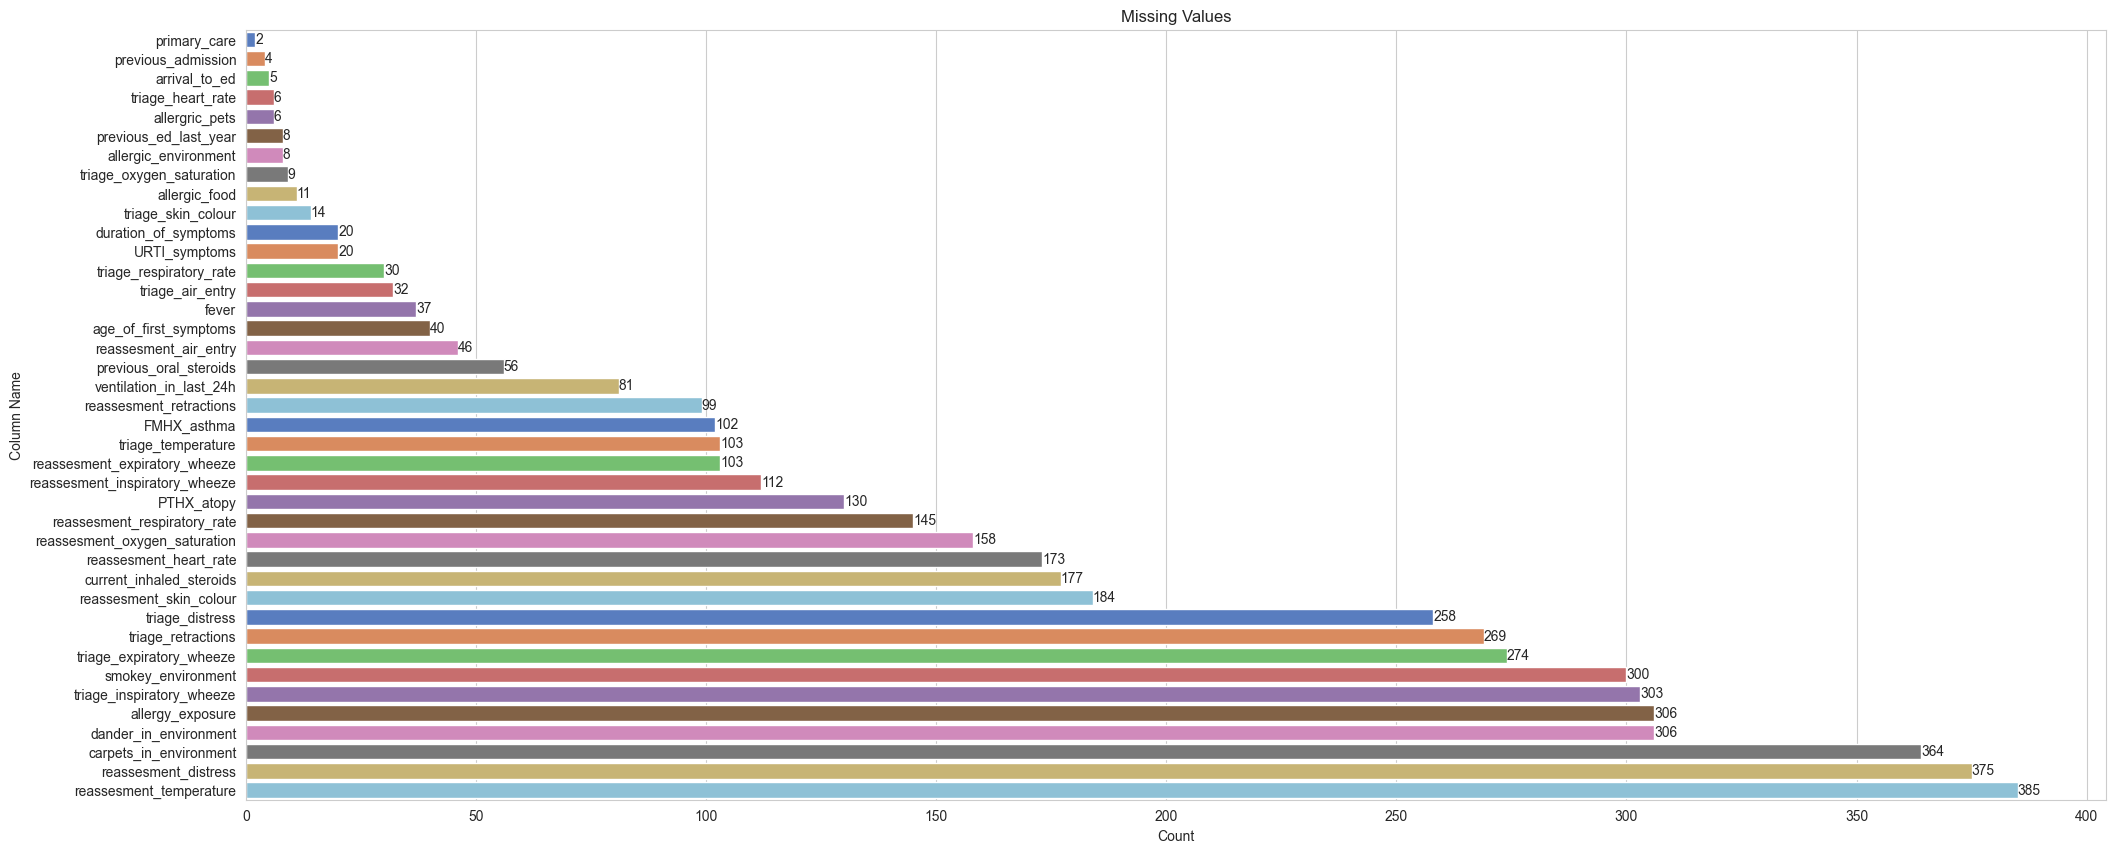

In [6]:
show_missing_values(dataframe)

#### Wykresy - korelacja między atrybutami
Wykres przedstawiający korelację między atrybutami.

C:\Users\HououinKyouma\AppData\Local\Temp\ipykernel_29120\1706945137.py:94: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


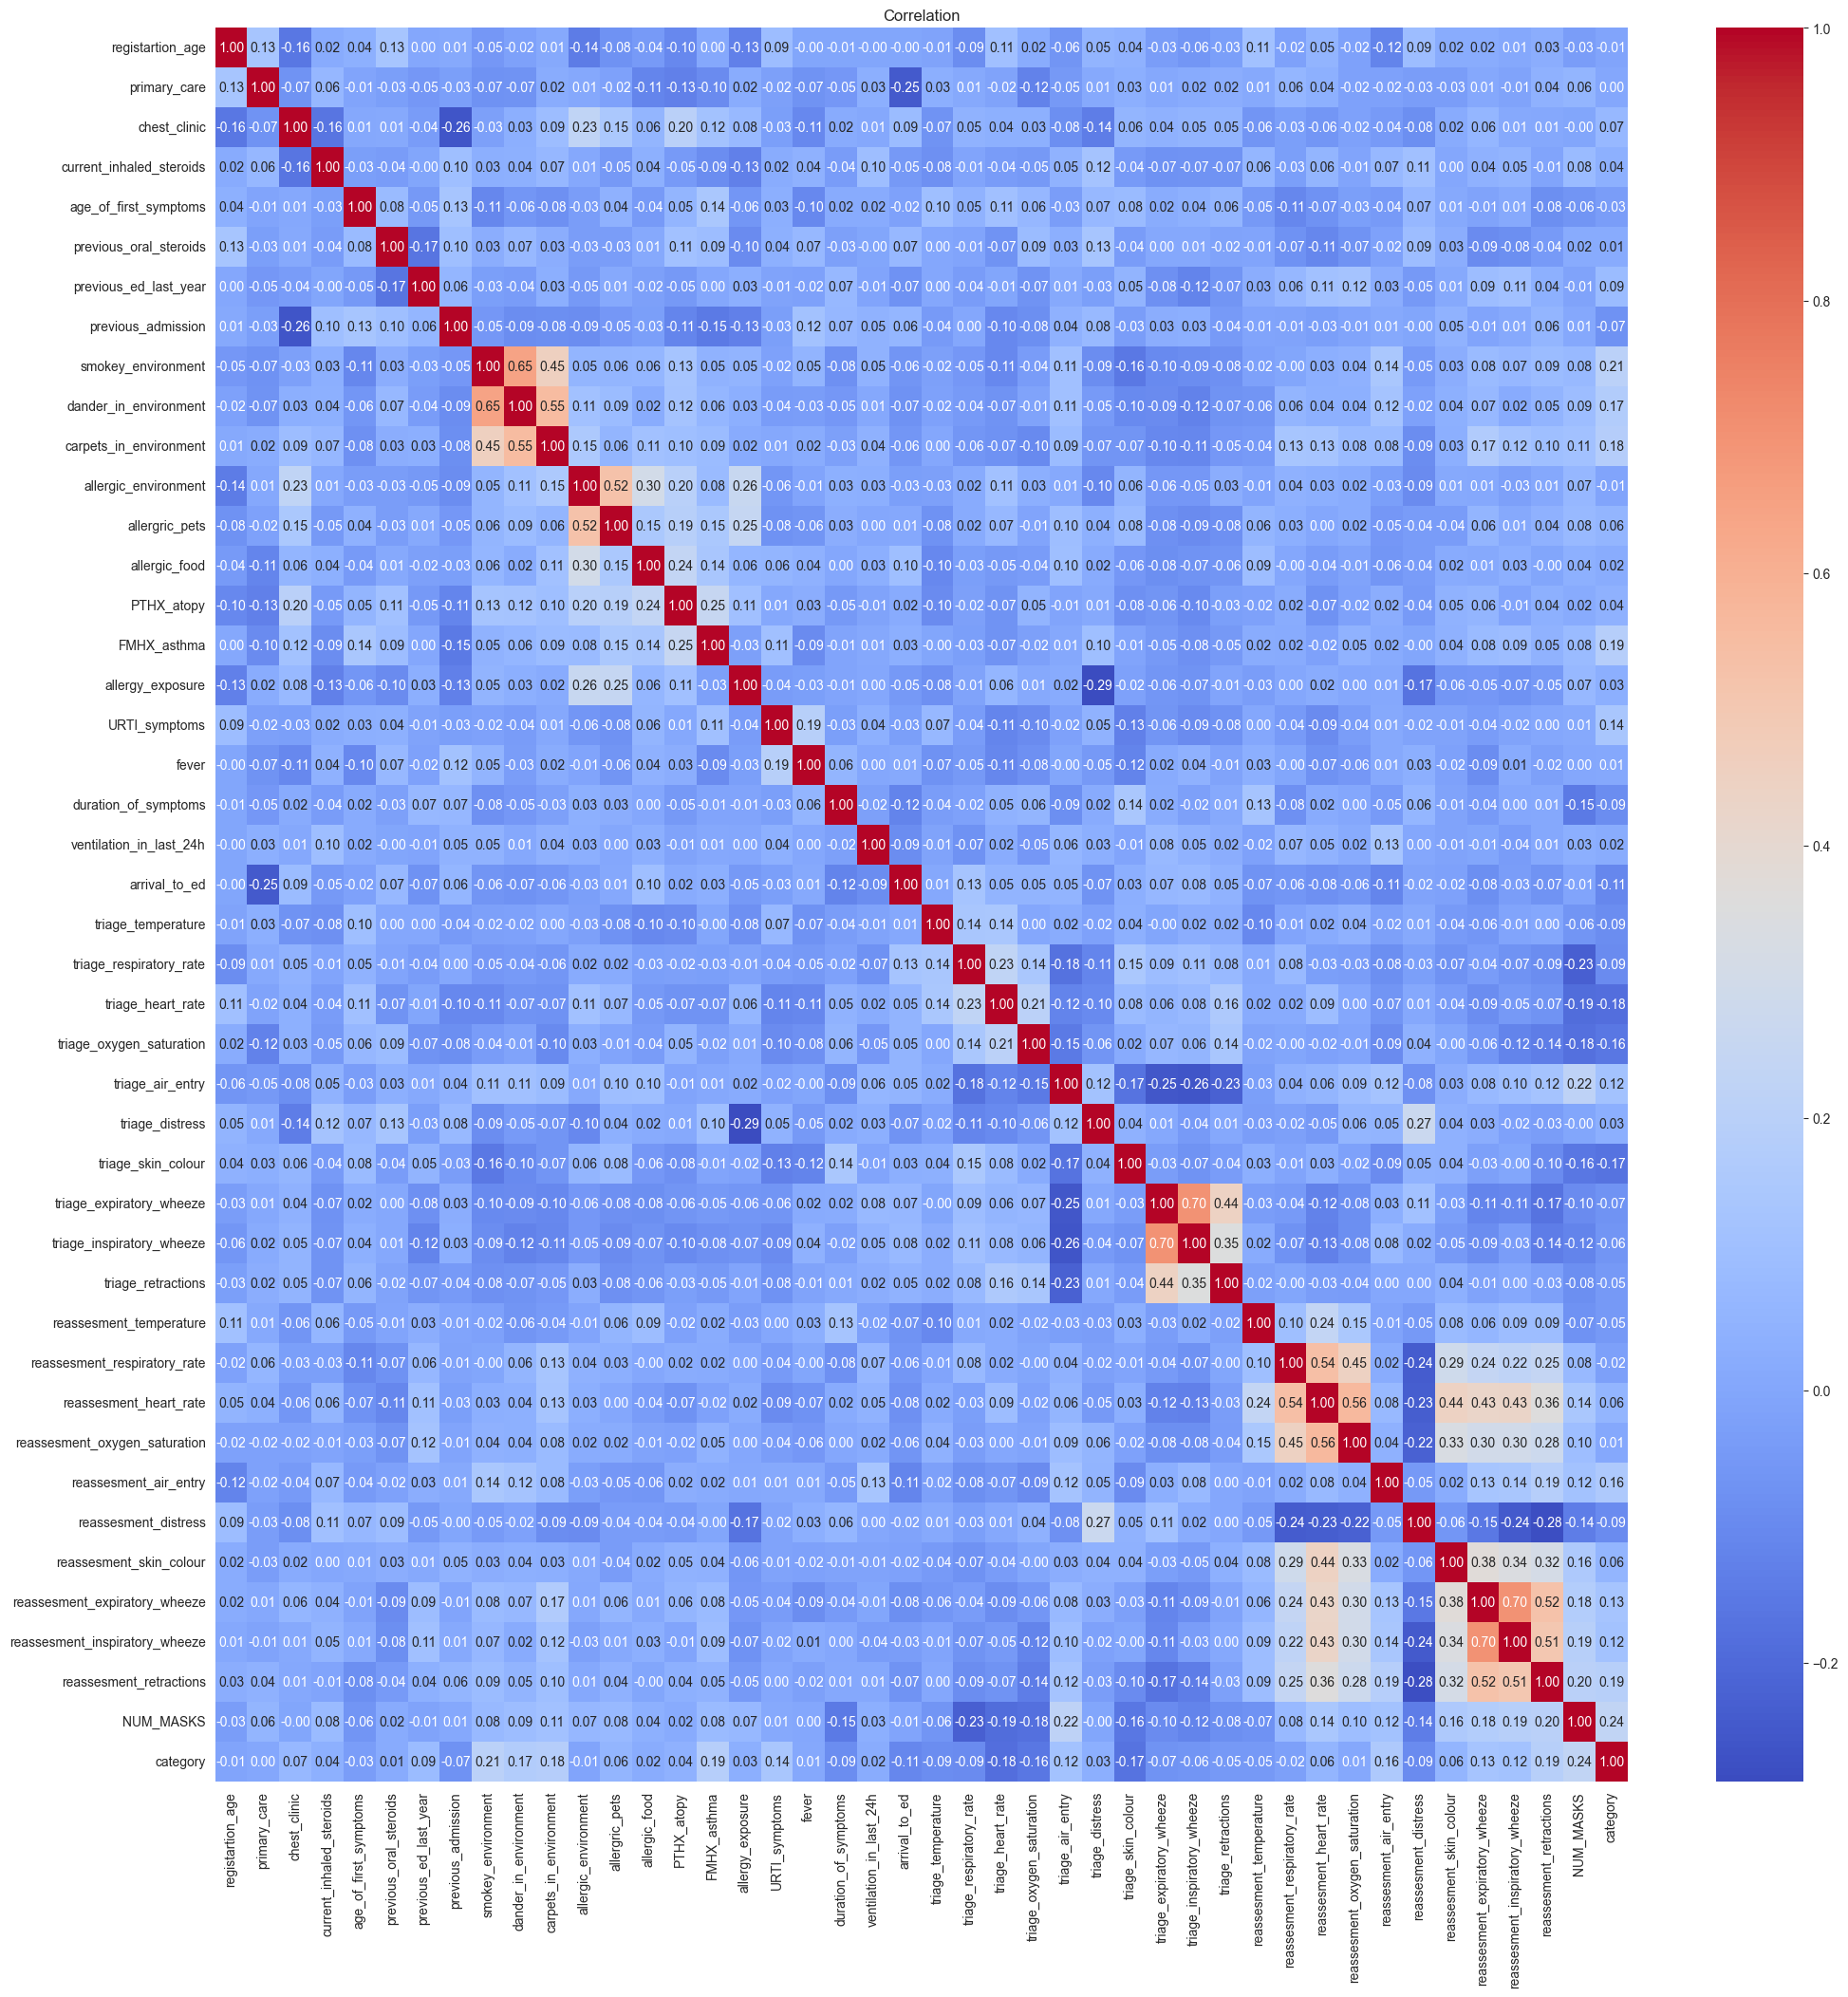

In [7]:
show_correlation(dataframe)

#### Wykresy - rozkład kategorii decyzyjnej

C:\Users\HououinKyouma\AppData\Local\Temp\ipykernel_29120\1706945137.py:129: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


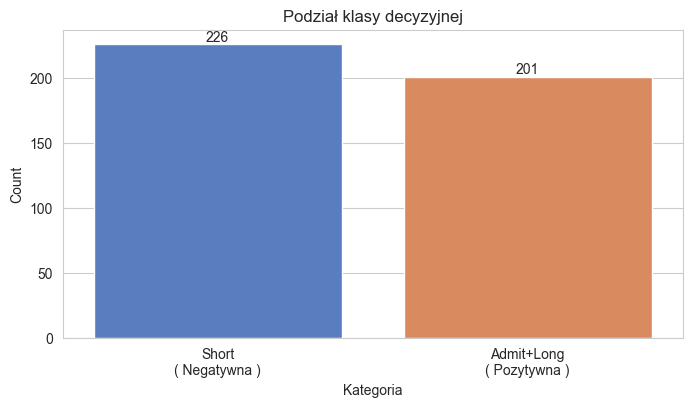

In [8]:
show_distribution(dataframe)

### Przygotowanie danych do modelu

In [9]:
y = dataframe['category']
X = dataframe.drop(columns=['category'])
X = pd.get_dummies(X, drop_first=True)


In [105]:
from typing import TypedDict, Protocol, Iterable
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy.typing import ArrayLike, NDArray
from sklearn import metrics

def calculate_auroc(real_labels: NDArray, fake_labels: NDArray) -> float:
  return metrics.roc_auc_score(real_labels, fake_labels)

def calculate_auprc(real_labels: NDArray, fake_labels: NDArray) -> float:
  precision, recall, _ = metrics.precision_recall_curve(real_labels, fake_labels)
  return metrics.auc(recall, precision)

def calculate_rates(real_labels: np.ndarray, fake_labels: np.ndarray) -> tuple[float, float, float, float]:
  tn, fp, fn, tp = metrics.confusion_matrix(real_labels, fake_labels, labels=[False, True]).ravel()
  positives = tp + fn
  negatives = tn + fp
  
  sensitivity = tp / positives
  miss_rate = fn / positives
  fall_out = fp / negatives
  specificity = tn / negatives

  return sensitivity, miss_rate, fall_out, specificity


def make_decisions(responses: np.ndarray, medium_threshold: float, high_threshold: float) -> np.ndarray:
  return np.array([
    False if response < medium_threshold else True if response >= high_threshold else np.nan
    for response in responses
  ])


def find_thresholds(real_labels: NDArray, fake_labels: NDArray) -> tuple[float, float]:
  fpr, tpr, thresholds = metrics.roc_curve(real_labels, fake_labels)
  sensitivity, specificity = tpr, 1 - fpr

  medium_risk = thresholds[np.where(sensitivity >= 0.99)[0][0]] if np.any(sensitivity >= 0.99) else None
  high_risk = thresholds[np.where(specificity >= 0.90)[0][-1]] if np.any(specificity >= 0.90) else None

  return medium_risk, high_risk

class Classifier(Protocol):
  def fit(self, x: NDArray, y: NDArray) -> None: ...
  def predict(self, x: NDArray) -> NDArray: ...
  def predict_proba(self, x: NDArray) -> NDArray: ...

ValidationResult = TypedDict('ValidationResult', {
  'negatives': ArrayLike,
  'positives': ArrayLike,
  'unknowns': ArrayLike,
  'aurocs': ArrayLike,
  'auprcs': ArrayLike,
  'rates': ArrayLike,
})
def calculate_k_fold_cross_validation(
    model: Classifier,
    values: NDArray,
    labels: NDArray,
) -> ValidationResult:
  kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
  rates = []
  aurocs = []
  auprcs = []
  negatives = []
  positives = []
  unknowns = []

  for train, test in kfold.split(values, labels):
    model.fit(values[train], labels[train])
    real_values = values[test]
    real_labels = labels[test]
    fake_labels = model.predict(real_values)
    fake_responses = model.predict_proba(real_values)[:, 1]

    aurocs.append(calculate_auroc(real_labels, fake_labels))
    auprcs.append(calculate_auprc(real_labels, fake_labels))

    medium_threshold, high_threshold = find_thresholds(real_labels, fake_responses)

    decisions = make_decisions(fake_responses, medium_threshold, high_threshold)

    positive = np.sum(decisions == True)
    negative = np.sum(decisions == False)
    unknown = np.sum(np.isnan(decisions))

    total = len(real_values)
    negatives.append(negative / total)
    positives.append(positive / total)
    unknowns.append(unknown / total)

    mask = ~np.isnan(decisions)
    rates.append(calculate_rates(real_labels[mask], decisions[mask]))

  return {
    'negatives': negatives,
    'positives': positives,
    'unknowns': unknowns,
    'aurocs': aurocs,
    'auprcs': auprcs,
    'rates': rates,
  }



In [131]:
from sklearn.impute import KNNImputer
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier


def find_target_classifier(values: NDArray, labels: NDArray) -> GridSearchCV:
  pipeline = Pipeline((
    ('pca', PCA()),
    ('nb', GaussianNB())
  ))

  params = {
    'pca__n_components': [2, 4, 8, 12, 16, 20, 24, 36],
    'pca__whiten': [True, False],
    'nb__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5],
    'nb__priors': [None, [0.5, 0.5], [0.6, 0.4], [0.4, 0.6], [0.7, 0.3], [0.3, 0.7], [0.8, 0.2], [0.2, 0.8], [0.9, 0.1], [0.1, 0.9]],
  }

  scorer = make_scorer(calculate_auprc, response_method="predict_proba")
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

  search = GridSearchCV(
    pipeline,
    params,
    cv=cv,
    scoring=scorer,
    n_jobs=-1,
    verbose=1
  )

  values_train, _, labels_train, _ = train_test_split(values, labels, test_size=0.2, random_state=42)

  search.fit(values_train, labels_train)

  return search


In [132]:
values = X.to_numpy()
labels = y.to_numpy()
search_result = find_target_classifier(values, labels)

target_classifier = search_result.best_estimator_

Fitting 15 folds for each of 800 candidates, totalling 12000 fits


In [133]:
from sklearn.linear_model import LogisticRegression
base_classifier = LogisticRegression()

classifiers = {
  'base': base_classifier,
  'target': target_classifier,
}

results = {
  name: calculate_k_fold_cross_validation(classifier, values, labels)
  for name, classifier in classifiers.items()
}

In [134]:
print(search_result.best_params_, search_result.best_score_, search_result.best_estimator_)

{'nb__priors': None, 'nb__var_smoothing': 1e-09, 'pca__n_components': 12, 'pca__whiten': True} 0.7249901325649614 Pipeline(steps=[('pca', PCA(n_components=12, whiten=True)),
                ('nb', GaussianNB())])


In [135]:
def calculate_mean(values: ArrayLike) -> float:
  return np.mean(values)

def calculate_confusion_rate_mean(rates: ArrayLike) -> tuple[float, float, float, float]:
  rates = np.array(rates)
  return (
    calculate_mean(rates[:, 0]),
    calculate_mean(rates[:, 1]),
    calculate_mean(rates[:, 2]),
    calculate_mean(rates[:, 3]),
  )

def calculate_mean_results(results: ValidationResult) -> ValidationResult:
  return {
    'negatives': calculate_mean(results['negatives']),
    'positives': calculate_mean(results['positives']),
    'unknowns': calculate_mean(results['unknowns']),
    'aurocs': calculate_mean(results['aurocs']),
    'auprcs': calculate_mean(results['auprcs']),
    'rates': calculate_confusion_rate_mean(results['rates']),
  }

mean_results = {
  name: calculate_mean_results(result)
  for name, result in results.items()
}


C:\Users\HououinKyouma\AppData\Local\Temp\ipykernel_29120\3046382204.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


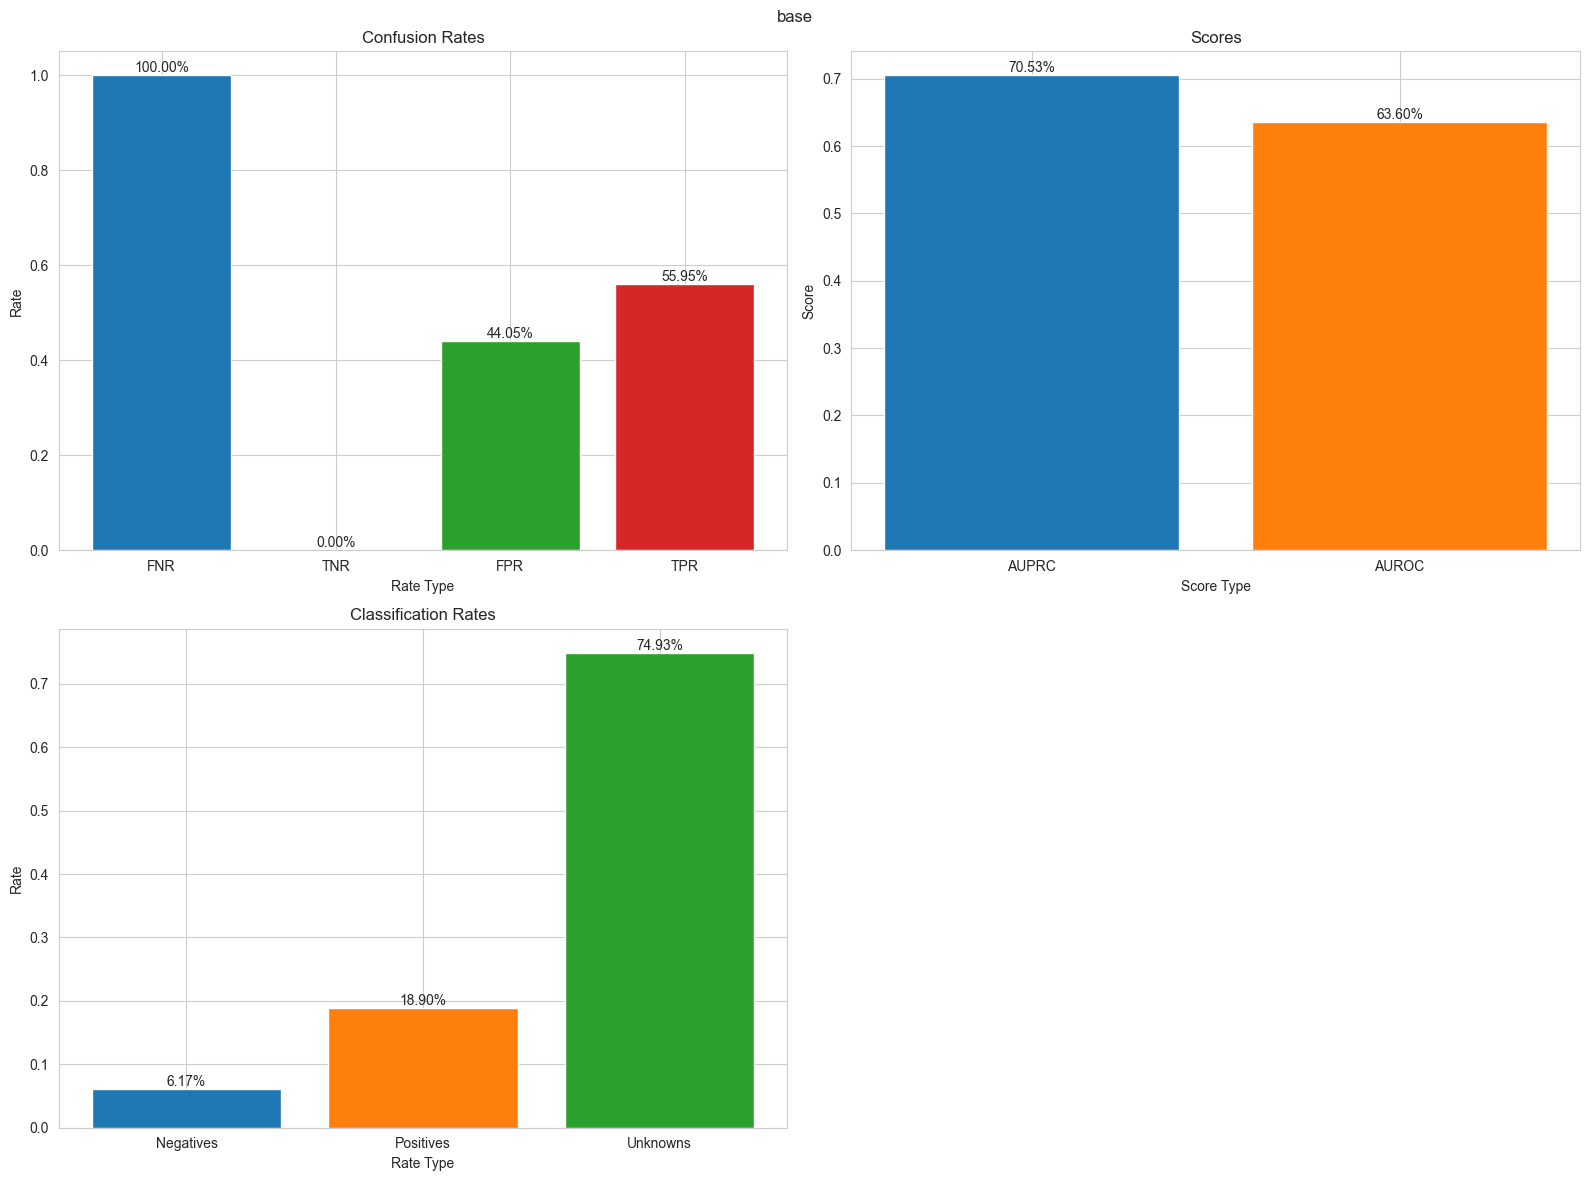

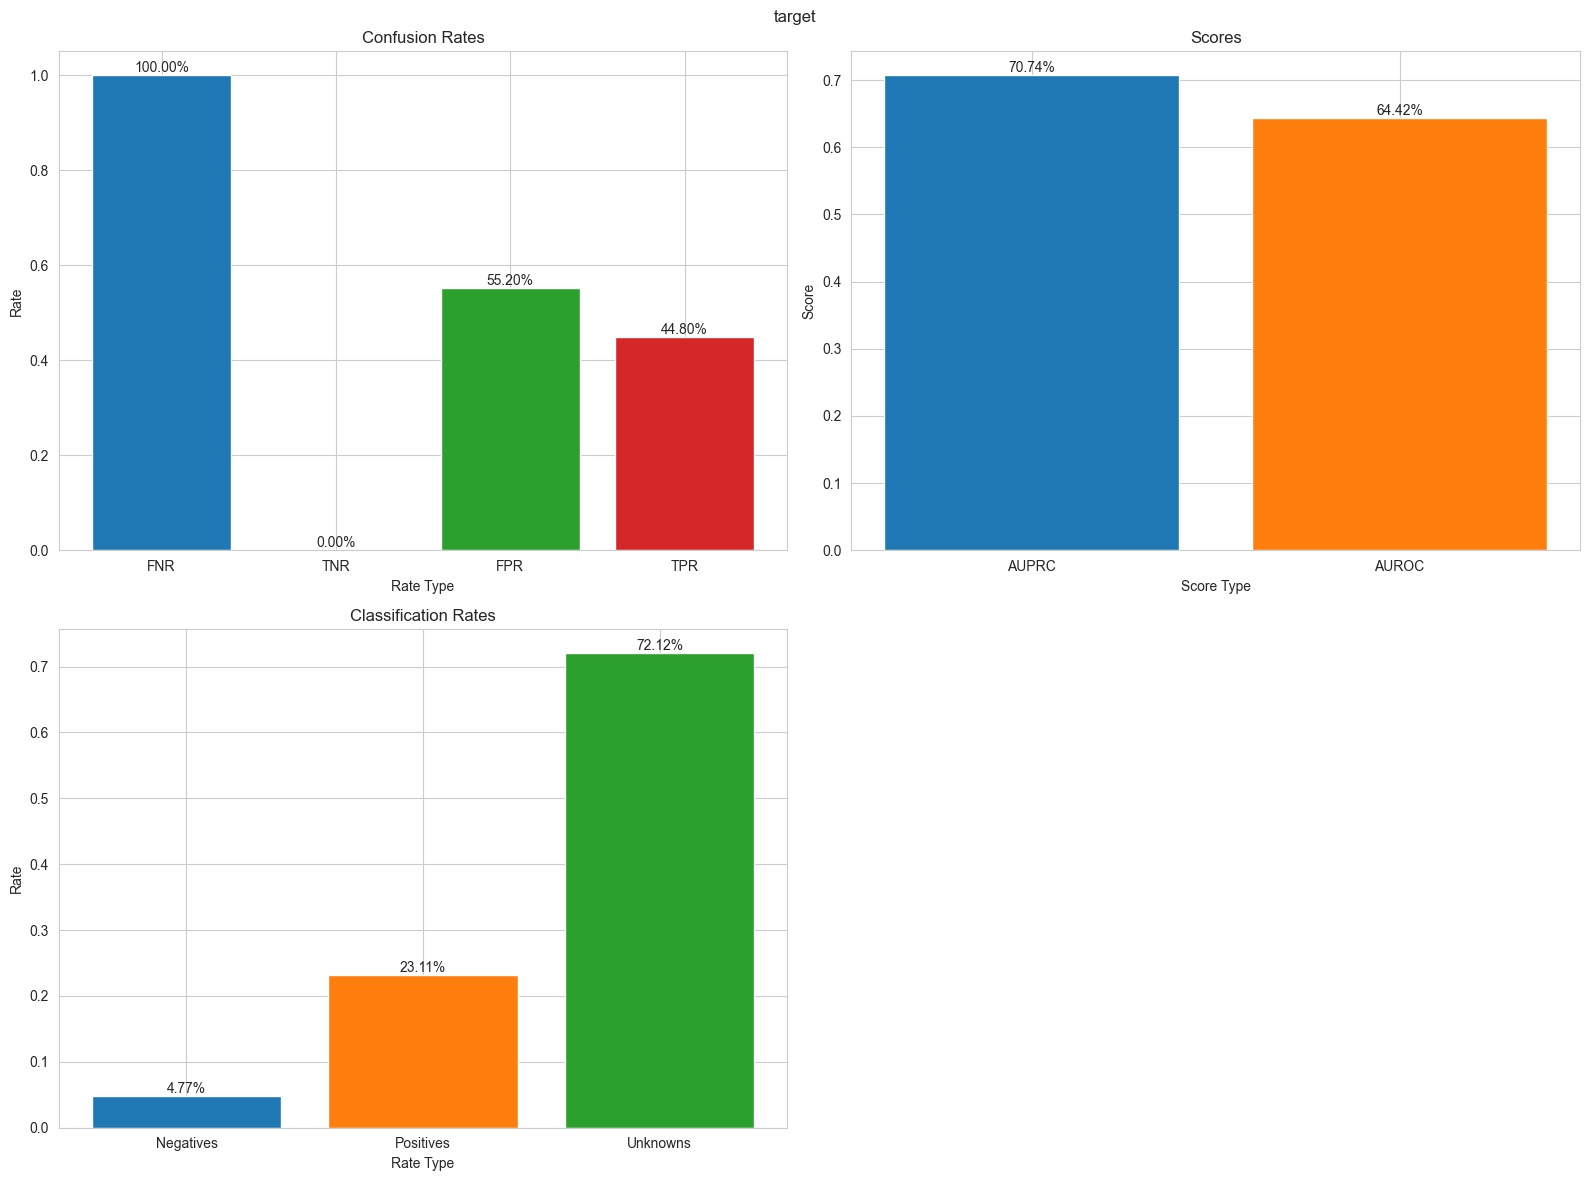

In [136]:
def plot_results(results: ValidationResult, title: str):
  figure, axis = plt.subplots(2, 2, figsize=(16, 12), tight_layout=True)

  axis[0, 0].bar(
    ['FNR', 'TNR', 'FPR', 'TPR'],
    results['rates'],
    color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
  )
  axis[0, 0].set_title('Confusion Rates')
  axis[0, 0].set_ylabel('Rate')
  axis[0, 0].set_xlabel('Rate Type')
  for i, value in enumerate(results['rates']):
    axis[0, 0].text(i, value, f'{value * 100:.2f}%', ha='center', va='bottom')

  axis[0, 1].bar(
    ['AUPRC', 'AUROC'],
    [results['auprcs'], results['aurocs']],
    color=['#1f77b4', '#ff7f0e']
  )
  axis[0, 1].set_title('Scores')
  axis[0, 1].set_ylabel('Score')
  axis[0, 1].set_xlabel('Score Type')
  for i, value in enumerate([results['auprcs'], results['aurocs']]):
    axis[0, 1].text(i, value, f'{value * 100:.2f}%', ha='center', va='bottom')

  axis[1, 0].bar(
    ['Negatives', 'Positives', 'Unknowns'],
    [results['negatives'], results['positives'], results['unknowns']],
    color=['#1f77b4', '#ff7f0e', '#2ca02c']
  )
  axis[1, 0].set_title('Classification Rates')
  axis[1, 0].set_ylabel('Rate')
  axis[1, 0].set_xlabel('Rate Type')
  for i, value in enumerate([results['negatives'], results['positives'], results['unknowns']]):
    axis[1, 0].text(i, value, f'{value * 100:.2f}%', ha='center', va='bottom')

  axis[1, 1].axis('off')

  figure.suptitle(title)
  figure.show()

for name, result in mean_results.items():
  plot_results(result, name)
